### H(z) Reconstrution via Gaussian Process (GP)

 /home/lazarolima/.local/lib/python3.12/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


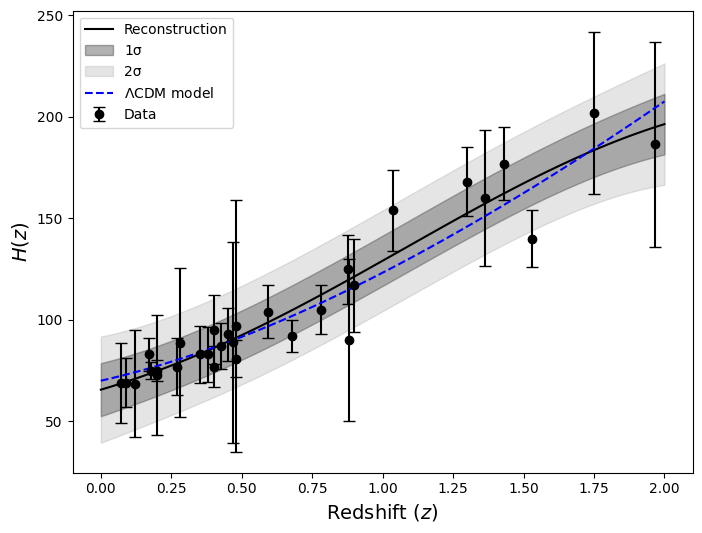

In [1]:
from gaussian_process import GPReconstructionH
from plots_rec import HReconstructionPlot
from equations import FiducialModel
import numpy as np

# Load your data
data_Hz = np.loadtxt('data/Hz31.txt')
z_values = data_Hz[:, 0]
H_obs = data_Hz[:, 1]
errors = data_Hz[:, 2]

# Choose the GP parameters
kernel_par = {'input_dim': 1, 'variance': 100., 'lengthscale': 0.1}
gp_h = GPReconstructionH(z_values, H_obs, errors, kernel_par)
gp_h.optimize(num_restarts=10, verbose=False)
mean, var, mean_deriv, var_deriv = gp_h.predict()

fiducial_model = FiducialModel()

# Plot the figure
plotter = HReconstructionPlot(gp_h, fiducial_model)
plotter.plot('Figuras/H_reconstructed.png')

### H(z) Reconstrution via Artificial Neural Network (ANN): ReFANN code

In [ ]:
import refann as rf
import time
import numpy as np
import matplotlib.pyplot as plt

# Starting the ANN
start_time = time.time()

Hz = np.loadtxt('data/Hz31.txt')

rec = rf.ANN(Hz,mid_node=4096,hidden_layer=1,hp_model='rec_2')
rec.iteration = 30000
rec.train()
func = rec.predict(xpoint=np.linspace(0, 2, 201))
#func = rec.predict(xspace=(0, 2, 201)) #or use this
rec.save_func(path='data', obsName='Hz31') #save the reconstructed function

# rec.plot_loss()
rec.plot_func()
print ("Time elapsed: %.3f mins" %((time.time()-start_time)/60))
plt.show()

# Generating FRBs Mock data

#### DM_IGM reconstruction throught GP

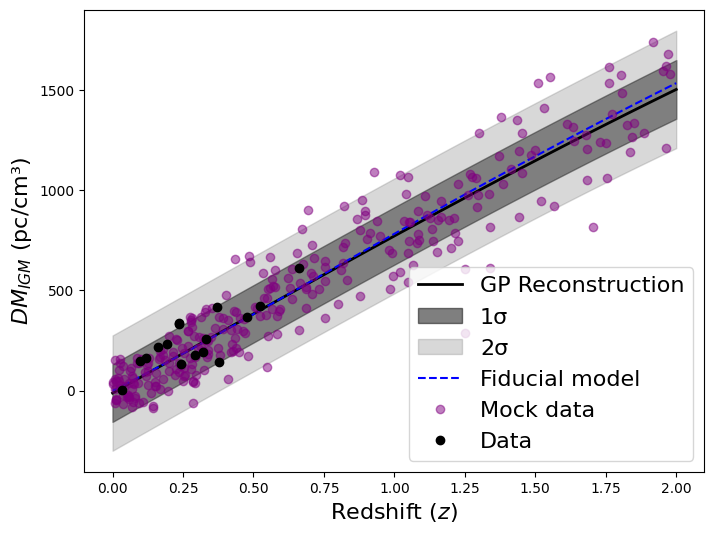

<Figure size 800x600 with 0 Axes>

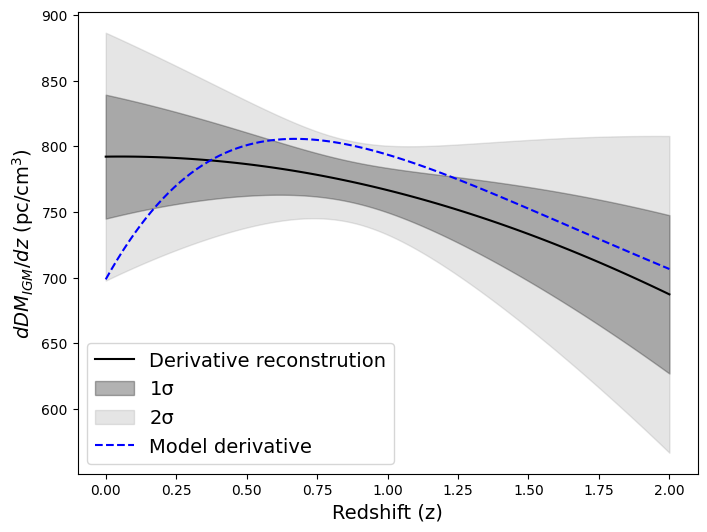

In [3]:
from gaussian_process import GPReconstructionDMIGM
from plots_rec import DMIGMReconstructionPlot
import numpy as np

# Parameters for generating new data mock via GP
n_new = 300  # Number of new data points
z_max = 2  # Máximo redshift
kernel_params = {'input_dim': 1, 'variance': 1., 'lengthscale': 0.2}
gp_dm_igm = GPReconstructionDMIGM(n_new, z_max, kernel_params)
gp_dm_igm.optimize(num_restarts=10, verbose=False)
new_z = gp_dm_igm.new_z
DM_IGM_sim = gp_dm_igm.DM_IGM_sim

# Plot the figures
plotter = DMIGMReconstructionPlot(gp_dm_igm, new_z, DM_IGM_sim)
plotter.plot_DM('Figuras/DM_IGM_reconstructed.png')
plotter.plot_dDM('Figuras/dDM_IGM_reconstructed.png')

#### DM_IGM reconstruction throught ANN

In [ ]:
import refann as rf
import time

DM_IGM = np.loadtxt('data/DM_IGM_sim.txt')

rec = rf.ANN(DM_IGM,mid_node=4096,hidden_layer=1,hp_model='rec_2')
rec.iteration = 30000
rec.train()
func = rec.predict(xpoint=np.linspace(0, 2, 201))
#func = rec.predict(xspace=(0, 2, 201)) #or use this
rec.save_func(path='data', obsName='DM_IGM') #save the reconstructed function

# rec.plot_loss()
rec.plot_func()


print ("Time elapsed: %.3f mins" %((time.time()-start_time)/60))
plt.show()

# Bayesian analyses and MCMC

### Defining priors

In [ ]:
from likelihood import Priors, LikelihoodFunction
from equations import H_Model

model = H_Model()

# Defining the prior intervals manually
intervals_constant = [(0, 1)]  # Interval for $f_{IGM}$
intervals_p2 = [(0, 1), (0, 5)]  # Intervals for $f_{IGM}$ and $\alpha$
intervals_p3 = [(0, 1), (0, 5)]  # Intervals for $f_{IGM}$ and $\alpha$
intervals_p4 = [(0, 1), (-5, 5)]  # Intervals for $f_{IGM}$ and $s$

# Creating specific instances of the priors
P_constant = Priors(['$f_{IGM}$'], intervals_constant)
P_p2 = Priors(['$f_{IGM}$', '$\\alpha$'], intervals_p2)
P_p3 = Priors(['$f_{IGM}$', '$\\alpha$'], intervals_p3)
P_p4 = Priors(['$f_{IGM}$', '$s$'], intervals_p4)

# Creating an instance of the likelihood model
LF_constant = LikelihoodFunction(lambda z, f_IGM: model.H_p(z, f_IGM, None, 'constant', 'ANN'))
LF_p2 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p2', 'ANN'))
LF_p3 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p3', 'ANN'))
LF_p4 = LikelihoodFunction(lambda z, f_IGM, s: model.H_p(z, f_IGM, s, 'p4', 'ANN'))
"""LF_constant = LikelihoodFunction(lambda z, f_IGM: model.H_p(z, f_IGM, None, 'constant'))
LF_p2 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p2'))
LF_p3 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p3'))
LF_p4 = LikelihoodFunction(lambda z, f_IGM, s: model.H_p(z, f_IGM, s, 'p4'))"""

### Preparing the samples

In [ ]:
from obs_data import H_data
import ultranest

z_values = H_data.z_func()
H_obs = H_data.H_func()
errors = H_data.errors_func()
model = H_Model()

# Configuring the ultranest samplers
sampler_constant = ultranest.ReactiveNestedSampler(P_constant.param_names,
    lambda params: LF_constant.log_likelihood(params, z_values, H_obs, errors),
    P_constant.prior_transform
)

sampler_p2 = ultranest.ReactiveNestedSampler(P_p2.param_names,
    lambda params: LF_p2.log_likelihood(params, z_values, H_obs, errors),
    P_p2.prior_transform
)

sampler_p3 = ultranest.ReactiveNestedSampler(P_p3.param_names,
    lambda params: LF_p3.log_likelihood(params, z_values, H_obs, errors),
    P_p3.prior_transform
)

sampler_p4 = ultranest.ReactiveNestedSampler(P_p4.param_names,
    lambda params: LF_p4.log_likelihood(params, z_values, H_obs, errors),
    P_p4.prior_transform
)


In [ ]:
result1 = sampler_constant.run(min_num_live_points=400)
sampler_constant.print_results()

In [ ]:
result2 = sampler_p2.run(min_num_live_points=400)
sampler_p2.print_results()

In [ ]:
result3 = sampler_p3.run(min_num_live_points=400)
sampler_p3.print_results()

In [ ]:
result4 = sampler_p4.run(min_num_live_points=400)
sampler_p4.print_results()

In [ ]:
from getdist import plots, MCSamples

# Extraindo amostras dos resultados
samples1 = result1['samples']
samples2 = result2['samples']
samples3 = result3['samples']
samples4 = result4['samples']

# Criando objetos MCSamples com os dados
labels1 = ['f_{IGM,0}']
names1 = ['f_IGM']
mcsamples1 = MCSamples(samples=samples1, names=names1, labels=labels1)

labels2 = ['f_{IGM,0}', '\\alpha']
names2 = ['f_IGM', 'alpha']
mcsamples2 = MCSamples(samples=samples2, names=names2, labels=labels2)
mcsamples3 = MCSamples(samples=samples3, names=names2, labels=labels2)

labels3 = ['f_{IGM,0}', 's']
names3 = ['f_IGM', 's']
mcsamples4 = MCSamples(samples=samples4, names=names3, labels=labels3)

In [ ]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples1.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples1, filled=True, contour_colors=['green'], 
                legend_labels=['P. 1'], 
                title_limit=1)
g.export('Figuras/H_p1.png', dpi=600)

In [ ]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples2.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples2, filled=True, contour_colors=['red'],
                legend_labels=['P. 2'], title_limit=1)
g.export('Figuras/H_p2.png', dpi=600)

In [ ]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples3.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples3, filled=True, contour_colors=['blue'],
                legend_labels=['P. 3'], title_limit=1)
g.export('Figuras/H_p3.png', dpi=600)

In [ ]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples4.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples4, filled=True, contour_colors=['purple'],
                legend_labels=['P. 4'], title_limit=1)
g.export('Figuras/H_p4.png', dpi=600)

In [ ]:
from ultranest.plot import PredictionBand
from equations import H_Model

plt.figure()
plt.xlabel('$z$')
plt.ylabel('H(z)')
plt.errorbar(x=z_values, y=H_obs, yerr=errors, marker='o', capsize=3, ls=' ', color='purple', label='$DM_{ext}^{obs}$')

band = PredictionBand(z_test.flatten())

# go through the solutions
for f_IGM  in sampler_constant.results['samples']:
    # compute for each time the y value
    model = H_Model()
    band.add(model.H_p(z_test.flatten(), f_IGM=f_IGM))

band.line(color='k', linestyle='--', label='$H_{P1}$', linewidth=1.5)
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)

plt.legend()
plt.savefig('Figuras/H_bestfit.png', format='png', dpi=600)